In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm
from script import *

%matplotlib inline

In [2]:
plt.rc('figure', figsize=(18.0, 6.0))

## Load files

Selected dataid 4874 as initial building to test out

In [3]:
df_4874 = pickle.load(open('pickle_files/df_4874.p', 'rb'))
df_4874 = df_4874.sort_values('localhour', ascending=True)
df_4874.index = df_4874.apply(strip_tz, axis=1)

In [4]:
#set time period to October 2016
df_4874 = df_4874.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00',:]

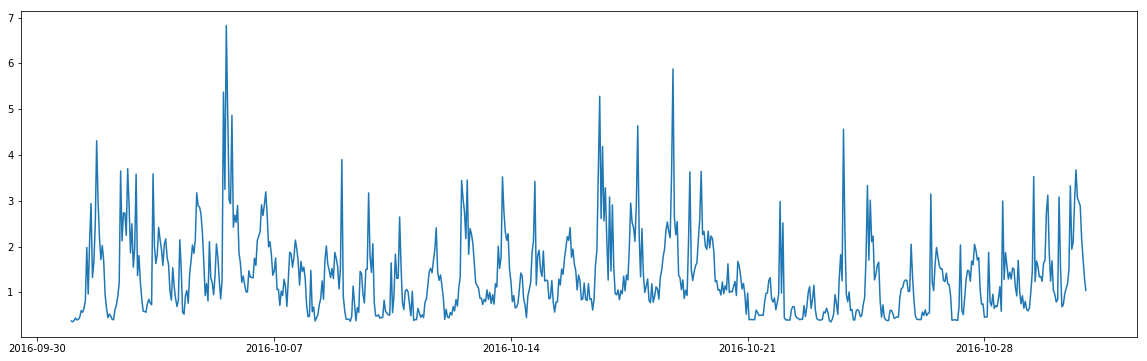

In [5]:
#plot electricity usage 
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_4874.localhour, df_4874.use)

## AR models

In [ ]:
#function to plot AR time series model with actual usage
def plot_ar_model(data, model, ar_value, building_name):

    x = data.localhour
    y_true = data.use

    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='actual usage')

    x_pred = x[ar_value:]
    y_pred = model.predict()

    #plot model prediction with AR
    plt.plot(x_pred,y_pred, color='red', label='predicted usage')

    plt.title("Electricity Usage of Building {} in April 2017 AR-{}".format(building_name, ar_value))
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption (kWh)")
    plt.legend()

AR1

In [6]:
#hourly_usage must be converted to list
AR1_model = sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=1)
print(AR1_model.params)

const     0.462993
L1.use    0.664593
dtype: float64


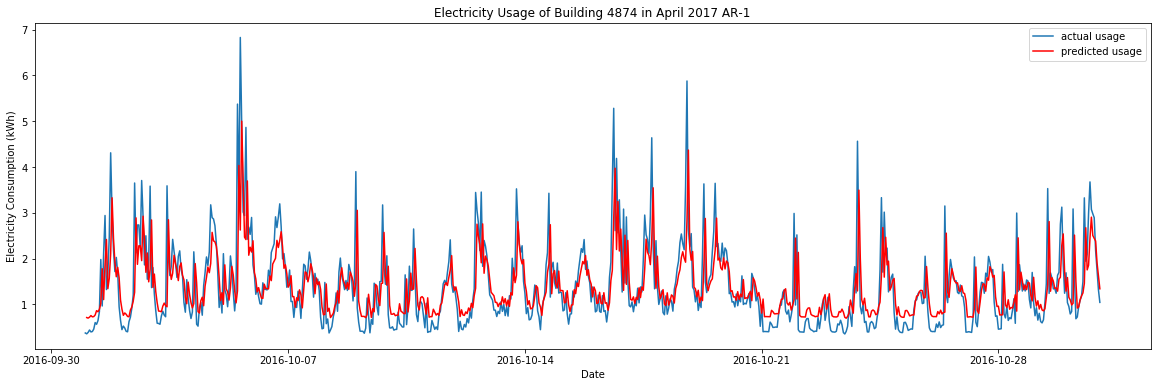

In [7]:
plot_ar_model(df_4874, AR1_model, 1, 4874)

AR2

In [8]:
AR2_model= sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=2)
print(AR2_model.params)

const     0.364730
L1.use    0.519676
L2.use    0.216738
dtype: float64


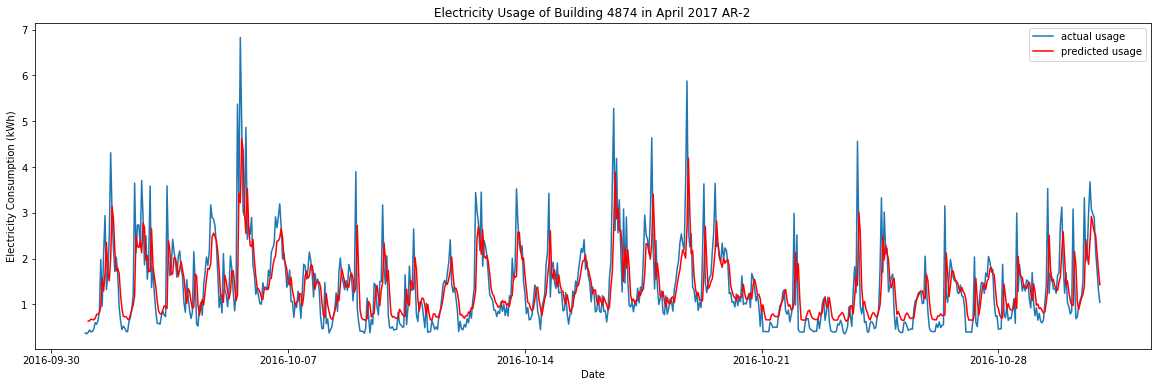

In [9]:
plot_ar_model(df_4874, AR2_model, 2, 4874)

AR3

In [10]:
AR3_model = sm.tsa.AR(df_4874.use, freq="H").fit(maxlag=3)
print(AR3_model.params)

const     0.343813
L1.use    0.506039
L2.use    0.184477
L3.use    0.061408
dtype: float64


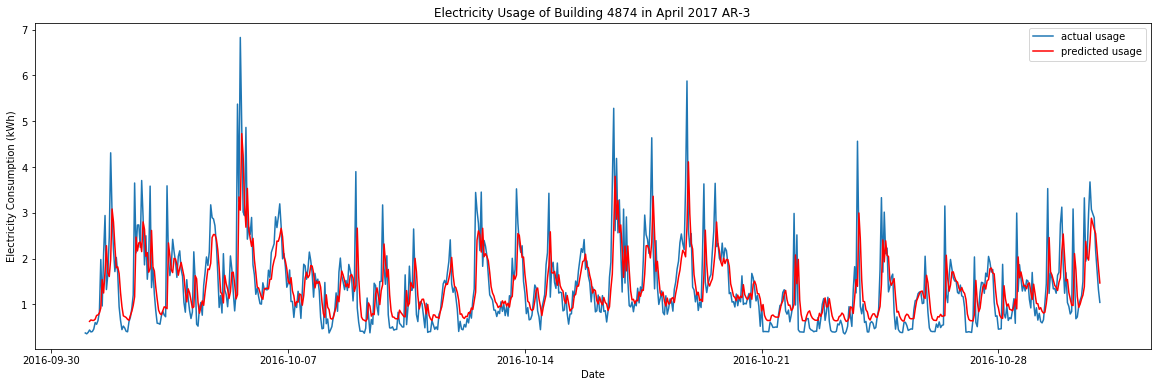

In [11]:
plot_ar_model(df_4874, AR3_model, 3, 4874)

## MA models

Moving Average (MA)

In [ ]:
#function to plot MA time series model with actual usage
def plot_ma_model(data, y_select, ma_value, building_name):

    x = data.index
    y_true = data.Hourly_Usage

    #plot actual usage
    plt.subplots(1,1,figsize=(20,6))
    plt.plot(x,y_true, label='actual usage')

    x_pred = x
    y_pred = y_select

    #plot model prediction with MA10
    plt.plot(x_pred,y_pred, color='red', label='predicted usage')

    plt.title("Electricity Usage of Building {} in April 2017 MA-{}".format(building_name, ma_value))
    plt.xlabel("Date")
    plt.ylabel("Electricity Consumption (kWh)")
    # plt.yscale('log')
    plt.legend()

In [12]:
#create new dataframe with time as index
df_4874_new = pd.DataFrame(df_4874.use)
df_4874_new["Hourly_Usage_MA10"] = pd.stats.moments.rolling_mean(df_4874_new, window=10, center=True)
df_4874_new.index = df_4874.apply(strip_tz, axis=1)
df_4874_new = df_4874_new.rename(columns={'use':'Hourly_Usage'})
df_4874_new.index = pd.to_datetime(df_4874_new.index)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


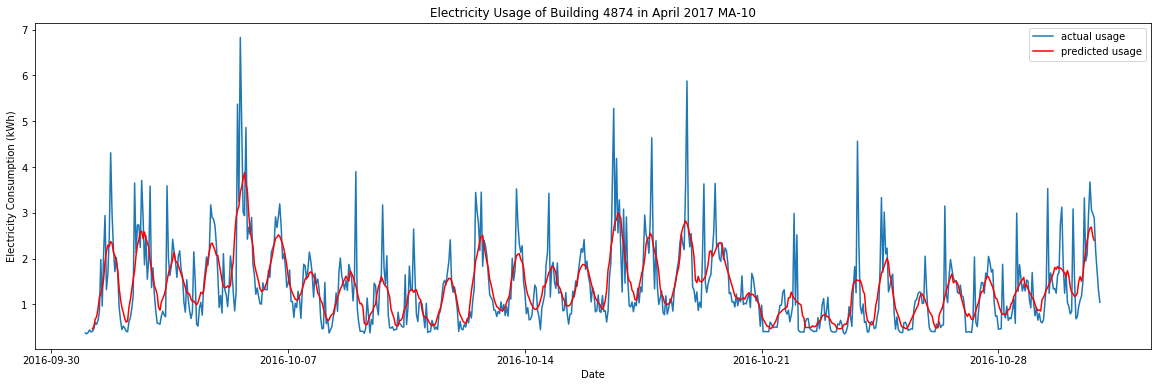

In [13]:
plot_ma_model(df_4874_new, df_4874_new["Hourly_Usage_MA10"], 10, 4874)

EWMA

In [14]:
ewma= pd.stats.moments.ewma(df_4874_new, halflife=5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,adjust=True,ignore_na=False,halflife=5).mean()
  """Entry point for launching an IPython kernel.


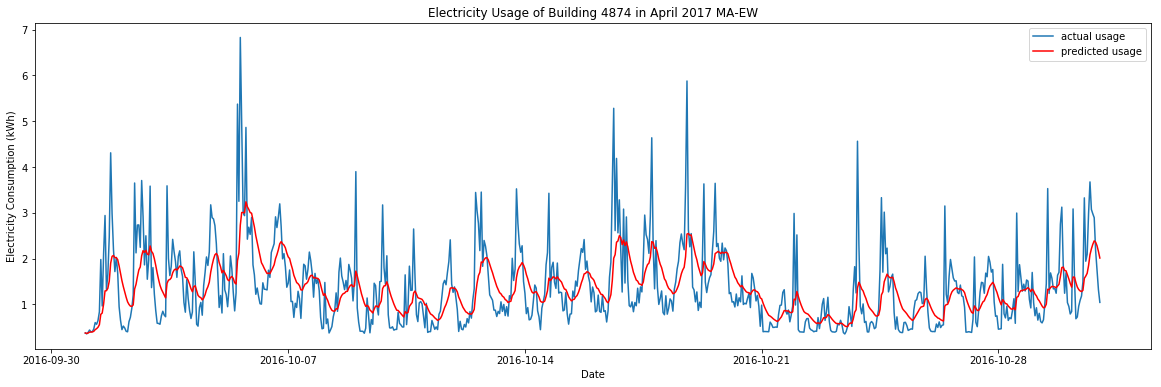

In [15]:
plot_ma_model(df_4874_new, ewma['Hourly_Usage'], 'EW', 4874)

## ARIMA models

In [16]:
import itertools
import seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Explore model

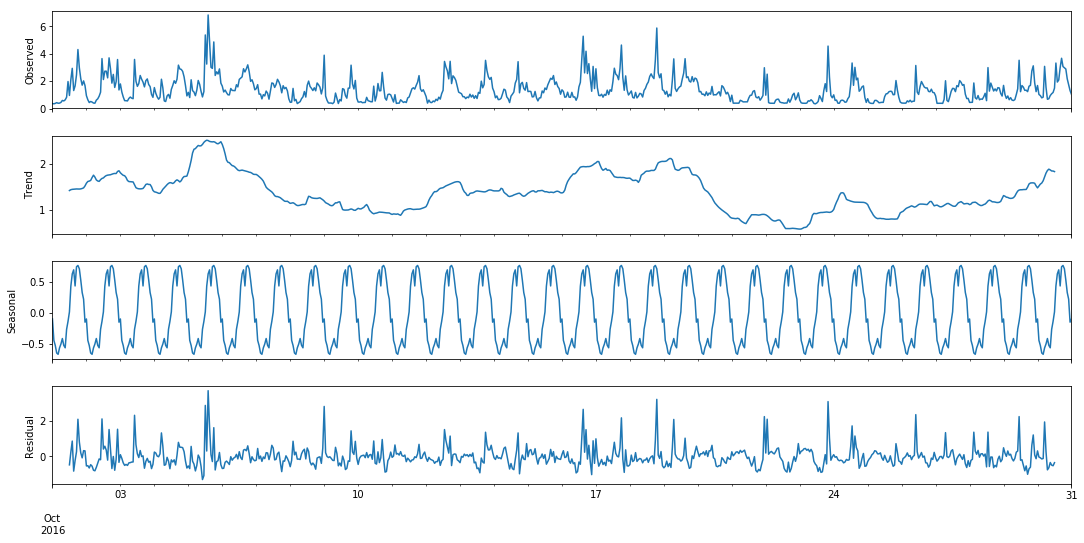

In [17]:
#plot seasonal decomposition
decomposition = seasonal_decompose(df_4874_new.Hourly_Usage, freq=24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

In [18]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

Test stationarity and perform Dickey-Fuller test

In [ ]:
#function to test stationarity
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24)
    rolstd = pd.rolling_std(timeseries, window=24)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

/home/kevinzhao/Project_Kojak/functions.py:63: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  rolmean = pd.rolling_mean(timeseries, window=24)
/home/kevinzhao/Project_Kojak/functions.py:64: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  rolstd = pd.rolling_std(timeseries, window=24)


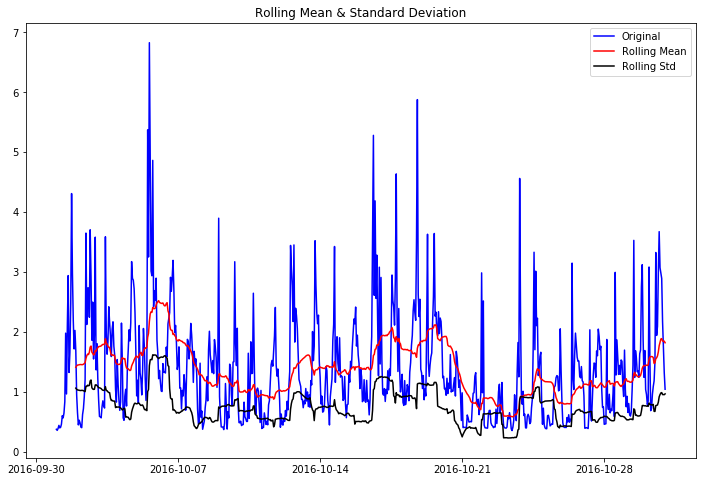

Results of Dickey-Fuller Test:
Test Statistic                  -2.758897
p-value                          0.064389
#Lags Used                      20.000000
Number of Observations Used    700.000000
Critical Value (1%)             -3.439726
Critical Value (10%)            -2.568973
Critical Value (5%)             -2.865678
dtype: float64


In [19]:
test_stationarity(df_4874_new.Hourly_Usage)

In [20]:
df_4874_new['first_difference'] = df_4874_new.Hourly_Usage - df_4874_new.Hourly_Usage.shift(1)
# test_stationarity(df_4874_new.first_difference)

In [21]:
df_4874_new['seasonal_difference'] = df_4874_new.Hourly_Usage - df_4874_new.Hourly_Usage.shift(24)
# test_stationarity(df_4874_new.seasonal_difference)

In [22]:
df_4874_new['seasonal_first_difference'] = df_4874_new.first_difference - df_4874_new.first_difference.shift(24)
# test_stationarity(df_4874_new.seasonal_first_difference)

PACF and ACF charts

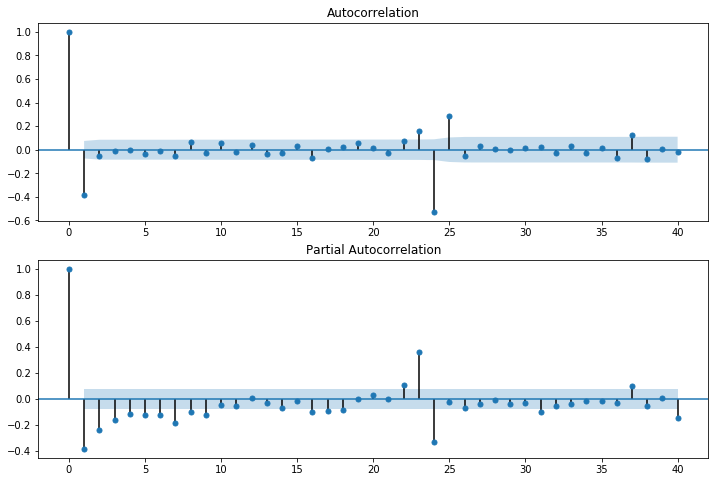

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_4874_new.seasonal_first_difference.iloc[25:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_4874_new.seasonal_first_difference.iloc[25:], lags=40, ax=ax2)

### Optimize order and seasonal order parameters in SARIMAX model

In [24]:
from datetime import datetime
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [ ]:
#function to find optimal parameters and resulting AIC score
def gridsearch_arima(y, exog=None):

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

    low_aic = [0,0,50000]

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y,
                                                  exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < low_aic[2]:
                    low_aic = [param, param_seasonal, results.aic]

#                 print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return low_aic

In [ ]:
#function to create training and testing set
def create_train_test(data, start_train, end_train, start_test, end_test):

    df_train = data.loc[start_train:end_train, :]
    df_test = data.loc[start_test:end_test, :]

    start = datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
    date_list = [start + relativedelta(hours=x) for x in range(0,24)] #test set will always have 24 hours
    future = pd.DataFrame(index=date_list, columns= df_train.columns)
    df_train = pd.concat([df_train, future])

    return df_train, df_test

In [ ]:
# define helper plot function for visualization
def acf_pacf_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [ ]:
#function to forecast with fitted model, returns MSE and RMSE
def add_forecast(model, test, train, start_time, end_time):

    train['forecast'] = model.predict(start=start_time, end=end_time)
    y_true = test.loc[start_time:end_time, 'Hourly_Usage']
    y_pred = train.loc[start_time:end_time, 'forecast']
    train.loc[start_time:end_time, 'Hourly_Usage'] = test.loc[start_time:end_time, 'Hourly_Usage']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return mse, rmse

In [ ]:
def plot_forecast(data, datapoints):
    fig = plt.figure(figsize=(16,8))
    plt.plot(data['Hourly_Usage'][datapoints:])
    plt.plot(data['forecast'])
    plt.legend()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [25]:
df_4874_train, df_4874_test = create_train_test(df_4874_new,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

In [26]:
y_train = df_4874_train.Hourly_Usage
# low_aic_1 = gridsearch_arima(y_train)

In [27]:
# low_aic_1

In [28]:
arima_1 = sm.tsa.statespace.SARIMAX(y_train,
                                  trend=None,
                                  order=(1,0,1),
                                  seasonal_order=(0,1,1,24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = arima_1.fit()

In [29]:
print(results.params)

ar.L1       0.851799
ma.L1      -0.493442
ma.S.L24   -0.912977
sigma2      0.373973
dtype: float64


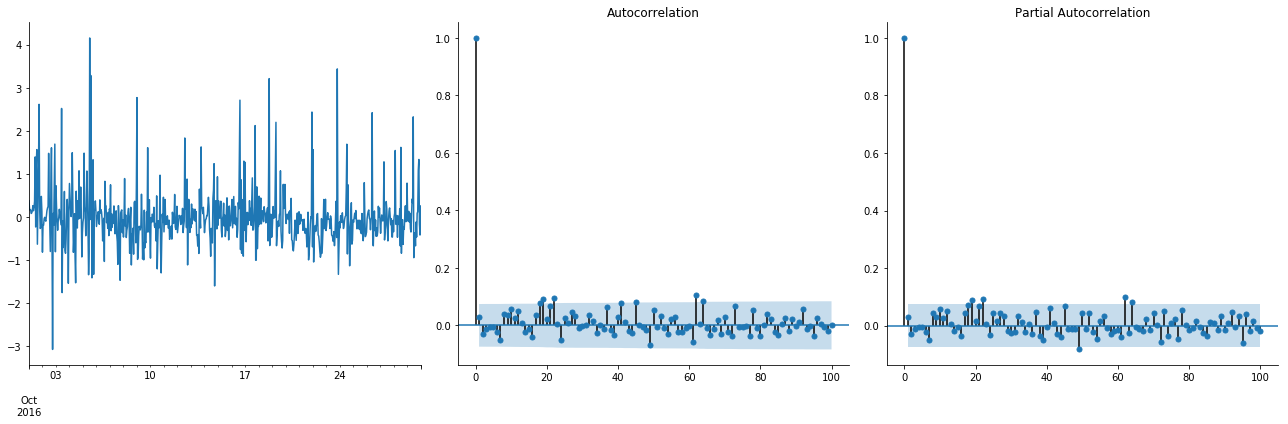

In [30]:
acf_pacf_plots(results.resid.dropna(), lags=100)

(0.70747995342206416, 0.84111827552494911)


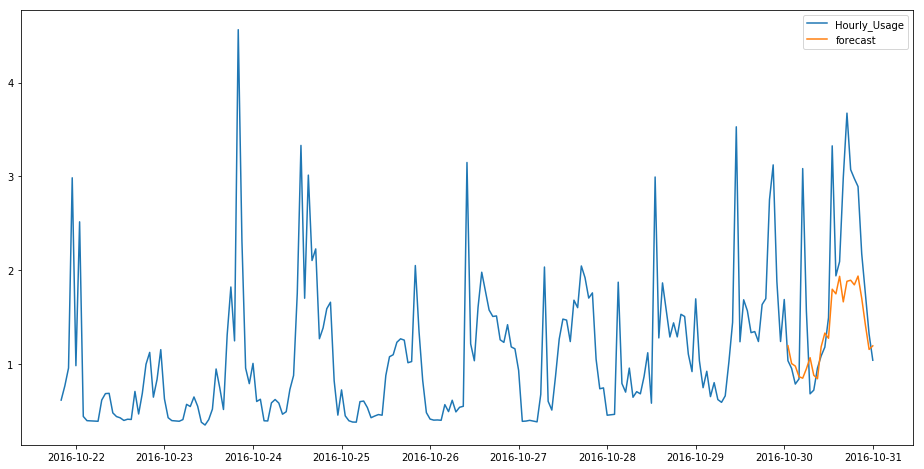

In [31]:
print(add_forecast(results, df_4874_test, df_4874_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_train, 500)

### Add exogenous variables to SARIMAX model

Ideas: day of week (weekend), weather

In [ ]:
#function to add all exogenous variables
def add_exog(data, weather, start_time, end_time):

    data['Day_of_Week'] = data.index.dayofweek
    data['Weekend'] = data.apply(is_weekend, axis=1)
    data['Temperature'] = weather.loc[start_time:end_time, 'temperature']

    return data

In [ ]:
df_weather_austin = pickle.load(open('weather_austin.p', 'rb'))
df_weather_austin = df_weather_austin.sort_values('localhour', ascending=True)
df_weather_austin.index =pd.to_datetime(df_weather_austin.apply(strip_tz, axis=1))

In [34]:
df_4874_exog = add_exog(df_4874_train, df_weather_austin,'2016-10-01 00:00:00', '2016-10-31 00:00:00')

#fill missing temperature values
df_4874_exog['Temperature'] = df_4874_train.Temperature.fillna(np.mean(df_4874_train['Temperature']))

exogenous = df_4874_exog.loc['2016-10-01 00:00:00':,['Weekend','Temperature']].astype(float)
endogenous = df_4874_exog.loc[:,'Hourly_Usage'].astype(float)
exogenous.shape, endogenous.shape

((721, 2), (721,))

In [53]:
gridsearch_arima(endogenous,exogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (0, 1, 1, 24), 1275.3275603897123]

In [35]:
arima_2 = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=(1, 0, 1),
                                  seasonal_order=(0, 1, 1, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_2 = arima_2.fit()

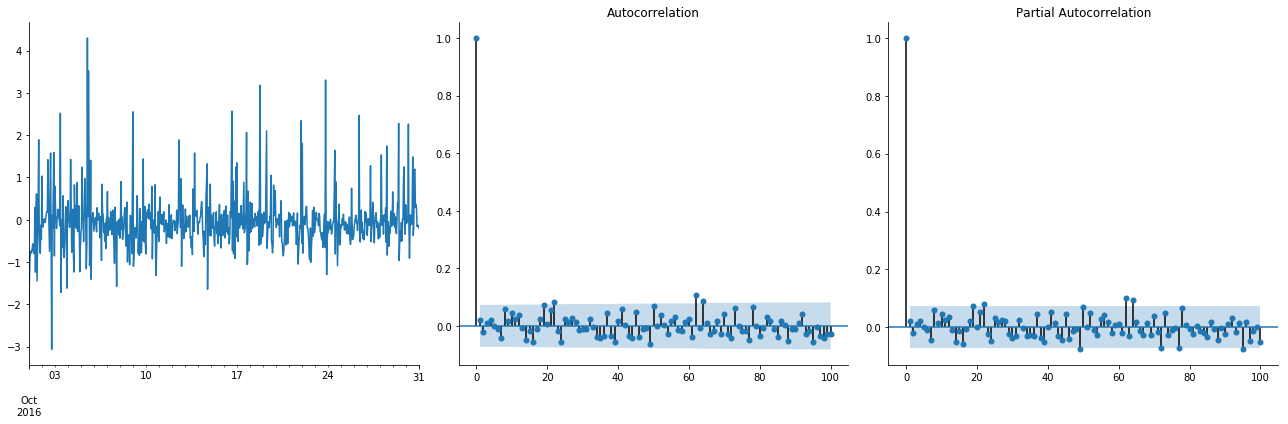

In [36]:
acf_pacf_plots(results_2.resid.dropna(), lags=100)

In [37]:
results.aic, results_2.aic

(1236.1592943463777, 1275.3275603897123)

Worse AIC score but let's see if the MSE is better

In [ ]:
df_4874_exog_train, df_4874_exog_test = create_train_test(df_4874_exog,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

(0.48780552498113128, 0.69843075890250661)


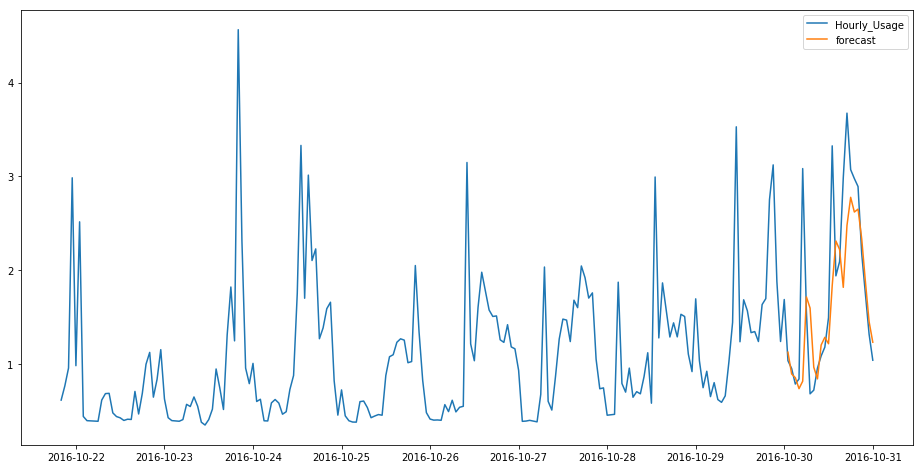

In [39]:
print(add_forecast(results_2, df_4874_exog_test, df_4874_exog_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_exog_train, 500)

Improved MSE with exogenous variables! Maybe add more

## GARCH model

In [40]:
import arch

In [41]:
df_4874.index = pd.to_datetime(df_4874.apply(strip_tz, axis=1))
arch_model = arch.arch_model(df_4874.use, p=1, q=1)
results_3 = arch_model.fit(update_freq=5)
print(results_3.summary)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 857.5600862542149
Iteration:     10,   Func. Count:     70,   Neg. LLF: 856.513665306034
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 856.5133810330773
            Iterations: 12
            Function evaluations: 82
            Gradient evaluations: 12
<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                    use   R-squared:                      -0.059
Mean Model:             Constant Mean   Adj. R-squared:                 -0.059
Vol Model:                      GARCH   Log-Likelihood:               -856.513
Distribution:                  Normal   AIC:                           1721.03
Method:            Maximum Likelihood   BIC:                           1739.35
                                        No. Observations:                  721
Date:                Wed, Sep 13 2017   Df Residuals:

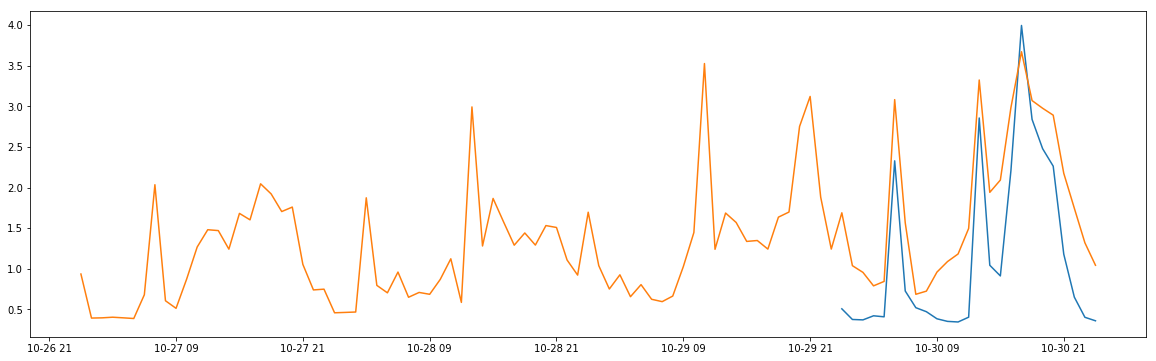

In [42]:
plt.subplots(1,1,figsize=(20,6))
arch_forecast = results_3.forecast(start='2016-10-30 00:00:00')
plt.plot(df_4874.localhour, arch_forecast.variance)
plt.plot(df_4874.loc['2016-10-27 00:00:00':'2016-10-31 00:00:00', 'localhour'],df_4874.loc['2016-10-27 00:00:00':'2016-10-31 00:00:00', 'use'])

In [43]:
mean_squared_error(df_4874.loc['2016-10-30 00:00:00':,'use'], arch_forecast.variance[-25:])

0.5585321707362042

## Facebook Prophet

In [44]:
from fbprophet import Prophet

In [45]:
df_4874_prophet = pd.DataFrame(df_4874_new.loc['2016-10-01 00:00:00':'2016-10-30 00:00:00','Hourly_Usage'])
df_4874_prophet.rename(columns={'Hourly_Usage':'y'}, inplace=True)
df_4874_prophet['ds'] = df_4874_prophet.index
df_4874_prophet['Temperature'] = df_weather_austin.loc['2016-10-01 00:00:00':'2016-10-30 00:00:00', 'temperature']

#fill NaN temperatures
df_4874_prophet.Temperature.fillna(np.mean(df_4874_prophet['Temperature']), inplace=True)

In [46]:
prophet = Prophet()
prophet.add_regressor('Temperature')
prophet.fit(df_4874_prophet)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [47]:
future = prophet.make_future_dataframe(periods=24, freq='H', include_history=False)
future.index = future.ds
future['Temperature'] = df_weather_austin.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00', 'temperature']
future.Temperature.fillna(np.mean(future['Temperature']),inplace=True)
future.head()

,ds,Temperature
ds,,
2016-10-30 01:00:00,2016-10-30 01:00:00,73.26
2016-10-30 02:00:00,2016-10-30 02:00:00,71.57
2016-10-30 03:00:00,2016-10-30 03:00:00,69.43
2016-10-30 04:00:00,2016-10-30 04:00:00,68.44
2016-10-30 05:00:00,2016-10-30 05:00:00,68.51


In [48]:
forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
19,2016-10-30 20:00:00,1.977062,1.193328,2.800616
20,2016-10-30 21:00:00,1.772290,0.974587,2.606709
21,2016-10-30 22:00:00,1.575155,0.825050,2.330016
22,2016-10-30 23:00:00,1.372069,0.541138,2.155245
23,2016-10-31 00:00:00,1.142477,0.348405,1.956542


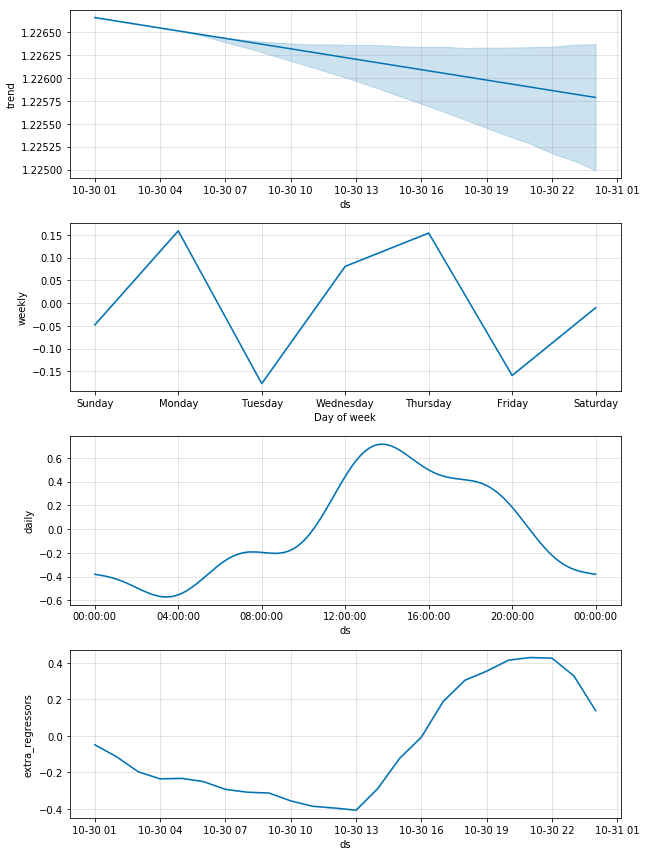

In [49]:
prophet.plot_components(forecast);

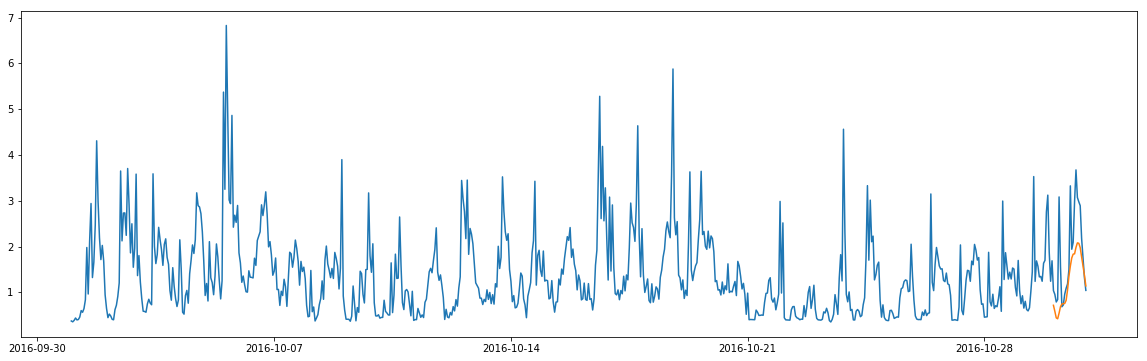

In [50]:
plt.subplots(1,1,figsize=(20,6))
plt.plot(df_4874.index,df_4874.use)
plt.plot(forecast.ds[-24:], forecast.yhat[-24:])

In [51]:
mean_squared_error(df_4874.use[-24:],forecast.yhat[-24:])

0.75385715780216744

## Baseline model scores (AR and MA)

In [52]:
df_4874_baseline_train, df_4874_baseline_test = create_train_test(df_4874_new,'2016-10-01 00:00:00','2016-10-30 00:00:00',
                                               '2016-10-30 01:00:00','2016-10-31 00:00:00')

In [53]:
df_4874_baseline_train.loc['2016-10-30 01:00:00':,'Hourly_Usage'] = np.nan

In [54]:
ar_baseline = sm.tsa.statespace.SARIMAX(endog=df_4874_baseline_train.Hourly_Usage,
                                  trend=None,
                                  order=(24, 0, 0),
                                  seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_4 = ar_baseline.fit()

(0.75908081012785333, 0.87125243765963334)


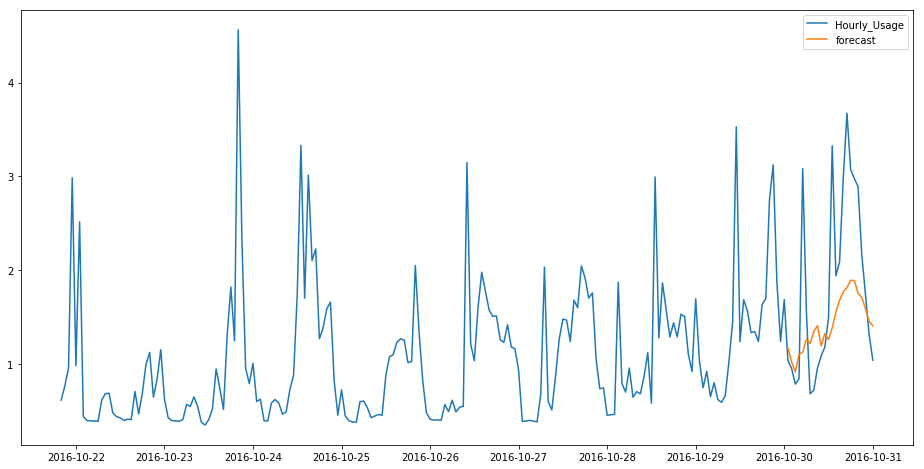

In [56]:
print(add_forecast(results_4, df_4874_baseline_test, df_4874_baseline_train,'2016-10-30 01:00:00','2016-10-31 00:00:00'))
plot_forecast(df_4874_baseline_train, 500)

-------

## Holt-Winters... needs further investigation

In [44]:
import seasonal as hw

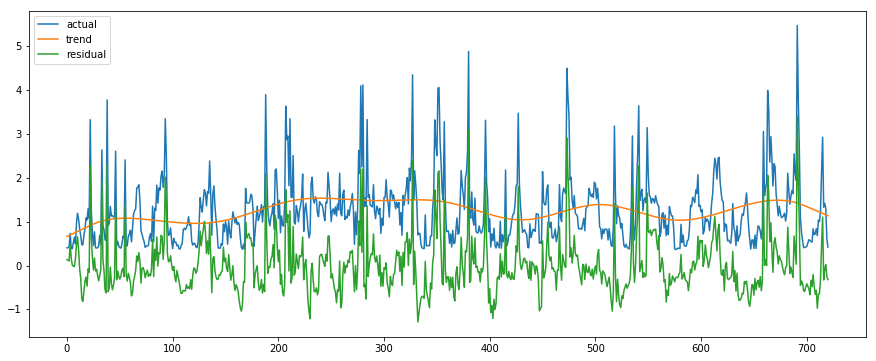

In [45]:
seasons, trend = hw.fit_seasons(y_true)
adjusted = hw.adjust_seasons(y_true, seasons=seasons)
residual = adjusted - trend
plt.subplots(1,1, figsize=(15,6))
plt.plot(y_true, label='actual')
plt.plot(trend, label='trend')
plt.plot(residual, label='residual')
plt.legend()